In [1]:
import pandas as pd 
from gensim.models import Word2Vec
from nltk.corpus import stopwords 
import numpy as np
from nltk.probability import FreqDist, MLEProbDist
import scipy
from scipy.linalg import svd
from sklearn.decomposition import PCA

In [2]:
def pre(filename):
    stop_words = set(stopwords.words('english')) 
    maharashtra = pd.read_csv(filename,index_col = False).sort_values('questions')

    query = list(maharashtra['questions'])
    kccans = list(maharashtra['answers'])
    district = list(maharashtra['district'])
    state = list(maharashtra['state'])

    final = []
    for i,w in enumerate(query):
        if query[i] != kccans[i]:
            if type(query[i]) == str:
                query[i] = query[i].replace('?','')
                query[i] = query[i].replace('(','')
                query[i] = query[i].replace(')','')

        if type(query[i]) != float:
            if type(kccans[i][0]) != float:
                row = [query[i].lower().strip(),kccans[i].lower().strip(),district[i].lower().strip(),state[i].lower().strip()]
                if row[0].isalpha() or len(row[0])>5:
                    final.append(row)

    maharashtra = pd.DataFrame(final)
    maharashtra.columns = ['Query','Ans','District','State']

    main = []
    for w in list(maharashtra['Query']):
        main.append(w.split(' '))

    new_maharashtra = []
    all_words = []
    for w,i in enumerate(main):
        temp = []
        for j in i:
            if j not in stop_words:
                temp.append(j)
                all_words.append(j)

        #new_maharashtra.append([maharashtra['District'][w],maharashtra["State"][w]] + temp)
        new_maharashtra.append(temp)

    t = FreqDist(all_words)
    u = FreqDist(district)
    v = FreqDist(state)
    
    return u,v,t,new_maharashtra,maharashtra

In [3]:
def word2vec_QAmodel(u,v,t,new_maharashtra,dimen,a,**pca):
        
    for key, value in pca.items(): 
        key = value

    model = Word2Vec(new_maharashtra, min_count = 1,size=dimen)

    word2vec_value = []
    for i in new_maharashtra:
        value = np.array([0.0 for k in range(dimen)])
        count = len(i)
        c = 0
        for j in i:
            c += 1
#             if c in [1]:
#                 factor = 1/(1 + u[j]/u.N())
#             if c in [2]:
#                 factor = 0.0001/(0.0001 + v[j]/v.N())
#             if c in [3,4,5]:
#                 factor = 1#a/(a + t[j]/t.N())
            factor = 1
            value += model[j]*factor

        value = value/count
        word2vec_value.append(value)
    
    if pca == 'Yes':
        X = np.array(word2vec_value)
        pca = PCA()
        pca.fit(X)

        u = pca.components_[0]
        u_t = np.transpose(u)
        u_ut = np.matmul(u,u_t)

        new_word2vec_value = []
        for i,w in enumerate(word2vec_value):
            sub = w - u_ut*np.array(w)
            new_word2vec_value.append(sub)

        word2vec_value = new_word2vec_value

    model.save('model_word2vec.bin')
    word2vec_value = np.matrix(word2vec_value)
    
    np.save('word2vec_value',word2vec_value)

In [4]:
def test_query(u,v,t,input_list,dimen,no_similar,a,**pca):
    
    word2vec_value = np.load('word2vec_value.npy')
    model = Word2Vec.load('model_word2vec.bin')
    
    district = input_list[0]
    state = input_list[1]
    sent = input_list[2]

    #sent_words = [district,state] + sent.split(" ")
    sent_words = sent.split(" ")

    sent_value = np.array([0.0 for k in range(dimen)])

    sent_new = []
    count = 0

    for i in sent_words:
        if i not in stop_words:
            try:
#                 if count in [0]:
#                     factor = 1/(1 + u[i]/u.N())
#                 if count in [1]:
#                     factor = 0.0001/(0.0001 + v[i]/v.N())
#                 if count in [2,3,4]:
#                     factor = 1#a/(a + t[i]/t.N())
                factor = 1
                sent_value += model[i]*factor
                count += 1

            except:
                count += 1
                continue

    sent_value = sent_value/count
    
    if pca == 'Yes':
        sent_value = sent_value - u_ut*np.array(sent_value)

    all_dist = []
    for i in word2vec_value:
        dist = scipy.spatial.distance.cosine(i,sent_value)
        all_dist.append(dist)

    k = no_similar
    ind = np.argpartition(all_dist, k)[:k]
    
    return ind

In [5]:
def print_ans(ind, pdf, k):
    
    #pdf = maharashtra
    pdf = pdf.reset_index()
    
    print 'Top-%d\n\n'%(k)
    for i in ind:
        print 'Question: %s\nAnswer: %s\n\n'%(pdf['Query'][i],pdf['Ans'][i])
    

In [7]:
u,v,t,new_maharashtra,maharashtra = pre('all_files.csv')

word2vec_QAmodel(u,v,t,new_maharashtra,50,0.001,pca='Yes')

# ind = test_query(u,v,t,['pune','maharashtra','blight attack on paddy'],50,5,0.001,pca='Yes')

# print_ans(ind, maharashtra, 5)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [4]:
main = pd.DataFrame()
for i in range(1,36):
    t = pd.read_csv('11_%d.csv'%(i))
    main = pd.concat([main,t])

In [5]:
main

,Unnamed: 0,BlockName,Category,CreatedOn,Crop,DistrictName,KCCAns,QueryText,QueryType,Season,Sector,StateName
0,0,ANDHERI ...,Others,2017-01-08 11:15:46.120,Others,Mumbai Suburban,Your SMS Registration process successfully com...,Asked About SMS Activation?,Government Schemes,RABI,AGRICULTURE,MAHARASHTRA
1,1,ANDHERI ...,Others,2017-01-11 15:57:00.280,Others,Mumbai Suburban,recommended for Aside from DIB hole clean fro...,farmer want to know information about collecti...,Cultural Practices\t,RABI,AGRICULTURE,MAHARASHTRA
2,2,ANDHERI ...,Fruits,2017-01-24 15:22:42.027,Pomegranate,Mumbai Suburban,"Jyothi, Ganesh, Co 1, YCD 1, Araktha, Rudhra, ...",Farmer wants to know information about varieti...,Cultural Practices,RABI,HORTICULTURE,MAHARASHTRA
3,3,BORIVALI ...,Fruits,2017-02-14 11:46:43.173,Orange,Mumbai Suburban,FERTILIZER FOR ORANGE = 0:52;34 60 GM + BOROC...,FERTILIZER FOR ORANGE,Fertilizer Use and Availability,KHARIF,HORTICULTURE,MAHARASHTRA
4,4,ANDHERI ...,Others,2017-02-26 14:07:29.170,Others,Mumbai Suburban,Recommended for Aside from DIB hole clean from...,Farmer needs information regarding collection ...,Cultural Practices\t,RABI,AGRICULTURE,MAHARASHTRA
5,5,BORIVALI ...,Others,2017-06-25 10:45:52.367,Others,Mumbai Suburban,NATIONAL INSURANCE COMPANY LTD. - 1800 200 7710,ASKING ABOUT CONTACT NUMBER FOR PRADHANMANTRI ...,Crop Insurance,KHARIF,AGRICULTURE,MAHARASHTRA
0,0,SHAHAPUR ...,Vegetables,2017-01-01 13:03:47.020,Cucumber,THANE,Spray super confidor 10 ml /15 liter of water(...,Attack of Aphids,\tPlant Protection\t,RABI,HORTICULTURE,MAHARASHTRA
1,1,VIKRAMGAD ...,Others,2017-01-01 13:35:02.270,Others,THANE,?????? ?????? (??./??.)-?.? - ?\r\n???????? ??...,?????? ???-?????(???-??? ? ???-????),\tPlant Protection\t,RABI,AGRICULTURE,MAHARASHTRA
2,2,BHIWANDI,Vegetables,2017-01-02 10:34:11.430,Cucumber,THANE,spray m-45 30 gm in 15 liter water.,Attack of Blight?,\tPlant Protection\t,RABI,HORTICULTURE,MAHARASHTRA
3,3,BHIWANDI,Others,2017-01-02 16:12:09.150,Others,THANE,This week weather is cloudy & not Possibility ...,farmer asked about Weather Report ?,Weather,RABI,AGRICULTURE,MAHARASHTRA


In [162]:
querytype_list = list(FreqDist(list(pd.read_csv('all_files.csv')['query-type'])))

In [8]:
model = Word2Vec.load('model_word2vec.bin')

In [12]:
for i,w in enumerate(new_maharashtra):
    new_maharashtra[i] = '\t'.join(w)

In [14]:
word2vec_value = np.load('word2vec_value.npy')

[-0.11113169379532337, -0.3475439067929983, -0.19117029635235666, -0.20260695070028306, -0.4079591417685151, 0.010375890252180397, 0.10374115142039955, 0.18919494953006505, 0.10314868083223701, -0.09768468802794814, -0.21762170903384687, -0.10360030373558402, 0.03828553366474807, -0.0738159264670685, -0.14869207553565503, 0.11829795632511378, 0.28633573539555074, -0.0020448240917176007, -0.282620663382113, -0.0875813535589259, -0.022774720354937016, -0.06828129263594747, 0.029626054340042174, -0.014500278762716335, -0.3511260263621807, -0.10541580123826862, 0.09474205654114484, -0.10778453070670366, 0.1270264414139092, -0.0369842627318576, 0.160378778912127, -0.16280733253806828, 0.07887311739614233, -0.19192543774843215, 0.28914197050035, 0.3054847398772836, 0.31581596583127974, -0.26234472151845695, 0.32685872837901114, 0.1391871377825737, 0.0044351418619044125, -0.3072462998330593, 0.1728650586679578, 0.4719153195619583, -0.04670782515313476, 0.18310446739196778, 0.46228787377476693

[-0.15745399706065655, -0.4405059330165386, -0.1816326156258583, -0.2461508996784687, -0.4415620528161526, -0.016511356341652572, 0.05707612494006753, 0.2562441620975733, 0.12344266846776009, -0.09288215730339289, -0.26421886682510376, -0.14540147595107555, 0.06114226579666138, -0.128467689268291, -0.1799454502761364, 0.10623219702392817, 0.4101594090461731, -0.027976596960797906, -0.3380327895283699, -0.08506214153021574, -0.04902172880247235, -0.09993079397827387, 0.07010813616216183, 0.009289984358474612, -0.4571322239935398, -0.11899861879646778, 0.13734311796724796, -0.15591191872954369, 0.13989316672086716, -0.02823535678908229, 0.19643212109804153, -0.11907131038606167, 0.11758532747626305, -0.2152195107191801, 0.3531627990305424, 0.39748770743608475, 0.3582318425178528, -0.3513377979397774, 0.3127923607826233, 0.15265516005456448, -0.04814468836411834, -0.44287408888339996, 0.1626023519784212, 0.5088093504309654, -0.13714858889579773, 0.2915845066308975, 0.5462174937129021, 0.0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [174]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
reduced = pca.fit_transform(word2vec_value)

t = reduced.transpose()

# plt.figure(figsize=(20, 20))
# plt.subplots(t[0], t[1])
# plt.show()

In [61]:
fig, ax = plt.subplots()
ax.scatter(t[0], t[1])

for i, txt in enumerate(yu):
    ax.annotate(txt, (t[0], t[1]))

Error in callback <function post_execute at 0x10f108de8> (for post_execute):


TypeError: only size-1 arrays can be converted to Python scalars

TypeError: only size-1 arrays can be converted to Python scalars

In [87]:
yu= list(maharashtra['Query'])
type(yu)

list

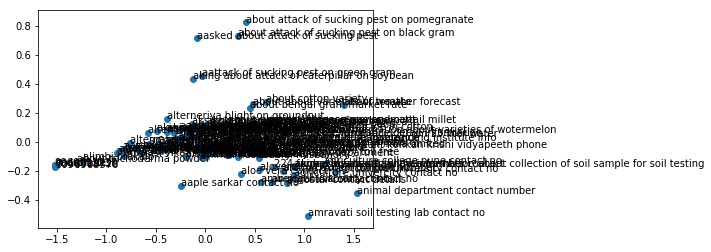

In [74]:
y = [2.56422, 3.77284, 3.52623, 3.51468, 3.02199]
z = [0.15, 0.3, 0.45, 0.6, 0.75]
n = ['what is the']

plt.figure(figsize=(20, 20))
fig, ax = plt.subplots()
plt.figure(figsize=(20, 20))
ax.scatter(t[0], t[1])

for i, txt in enumerate(yu):
    ax.annotate(txt, (t[0][i], t[1][i]))

In [82]:
maharashtra[14000:]

,Query,Ans,District,State
14000,wilt attack on bitter gourd,['drenching of blue copper 40 gm + humic acid ...,dhule,maharashtra
14001,wilt attack on black gram,['wilt attack on black gram-spray ridomil gold...,akola,maharashtra
14002,wilt attack on brinjal,['drenching of roko 15 gm / 15 liters of wate...,osmanabad,maharashtra
14003,wilt attack on capsicum,['drenching of blue copper 30 gm + humic acid ...,pune,maharashtra
14004,wilt attack on cauliflower,['drenching of blue copper 40 gm + humic acid ...,pune,maharashtra
14005,wilt attack on chilli,['drenching of blue copper 40 gm + humic acid ...,solapur,maharashtra
14006,wilt attack on cluster bean,['drenching of ridomil gold 30 gm / 15 liters ...,jalna,maharashtra
14007,wilt attack on coriander,['spray roko 15 gm / 15 liters of water (thiop...,latur,maharashtra
14008,wilt attack on cotton,['drenching blue copper 30gm + humic acid 30ml...,osmanabad,maharashtra
14009,wilt attack on custard apple,['wilt attack on custard apple = drenching of ...,aurangabad,maharashtra


In [132]:
y = []
n = []
z = []

for i in [14367,14366,14368,10005,10013,10006,14010,14011,14014]:
    y.append(t[0][i])
    z.append(t[1][i])
    n.append(yu[i])

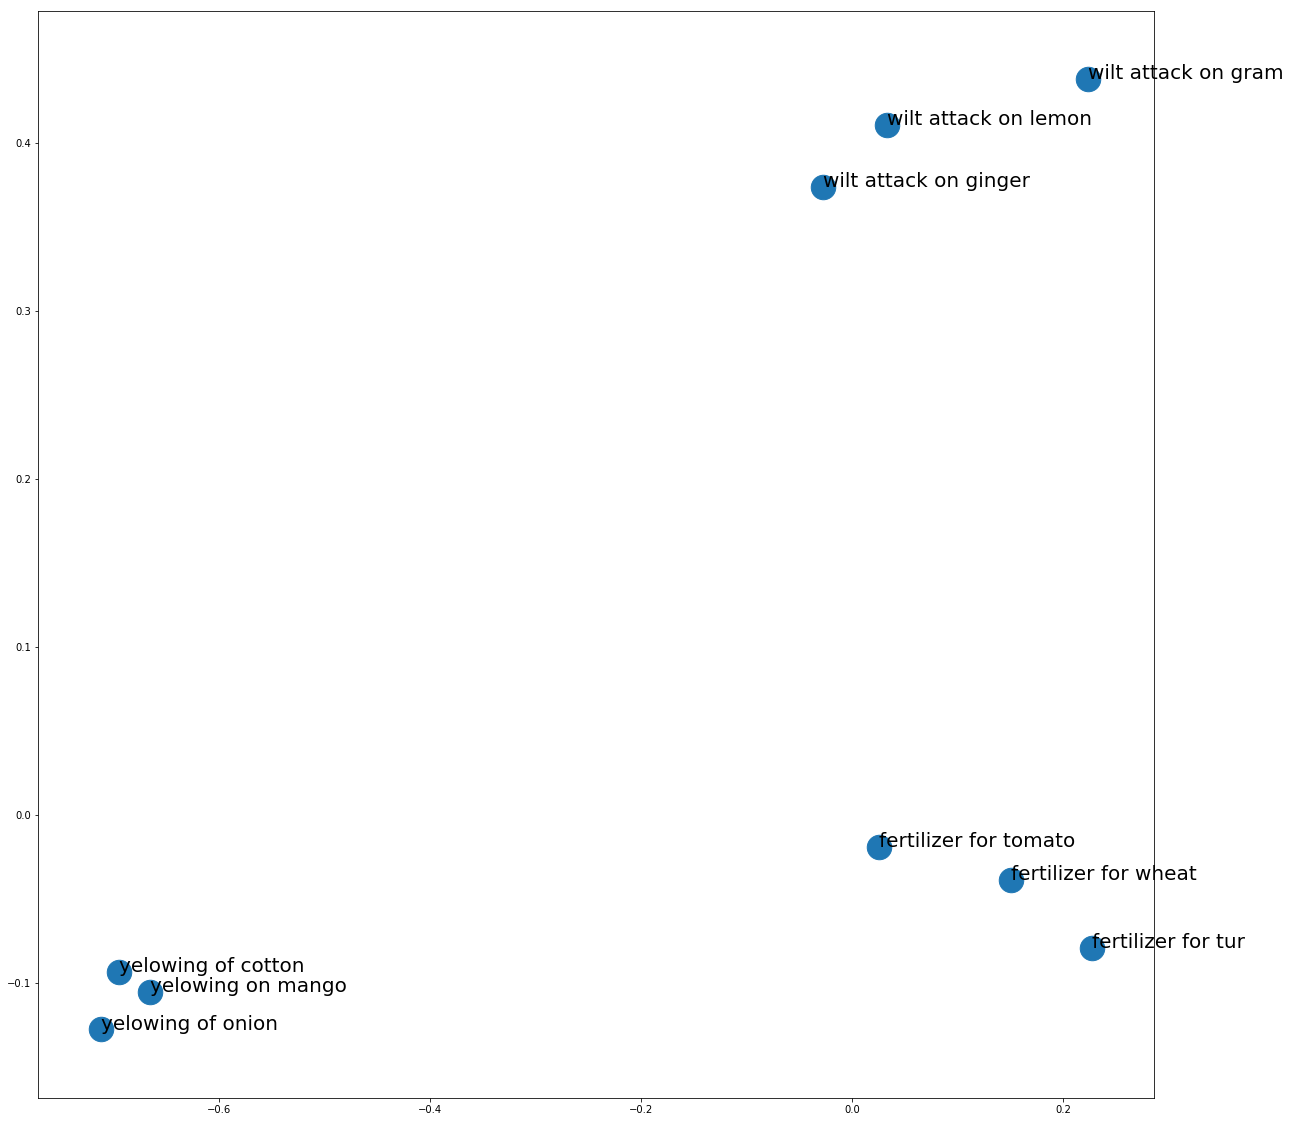

In [133]:
plt.figure(figsize=(20, 20))
plt.scatter(y, z, 600)
# plt.axis("off")

for i, txt in enumerate(n):
    plt.annotate(txt, (y[i], z[i]), fontsize = 20)

(-2.0390918113046794,
 2.6901662662497805,
 -0.8436945818690219,
 1.2014089496165659)

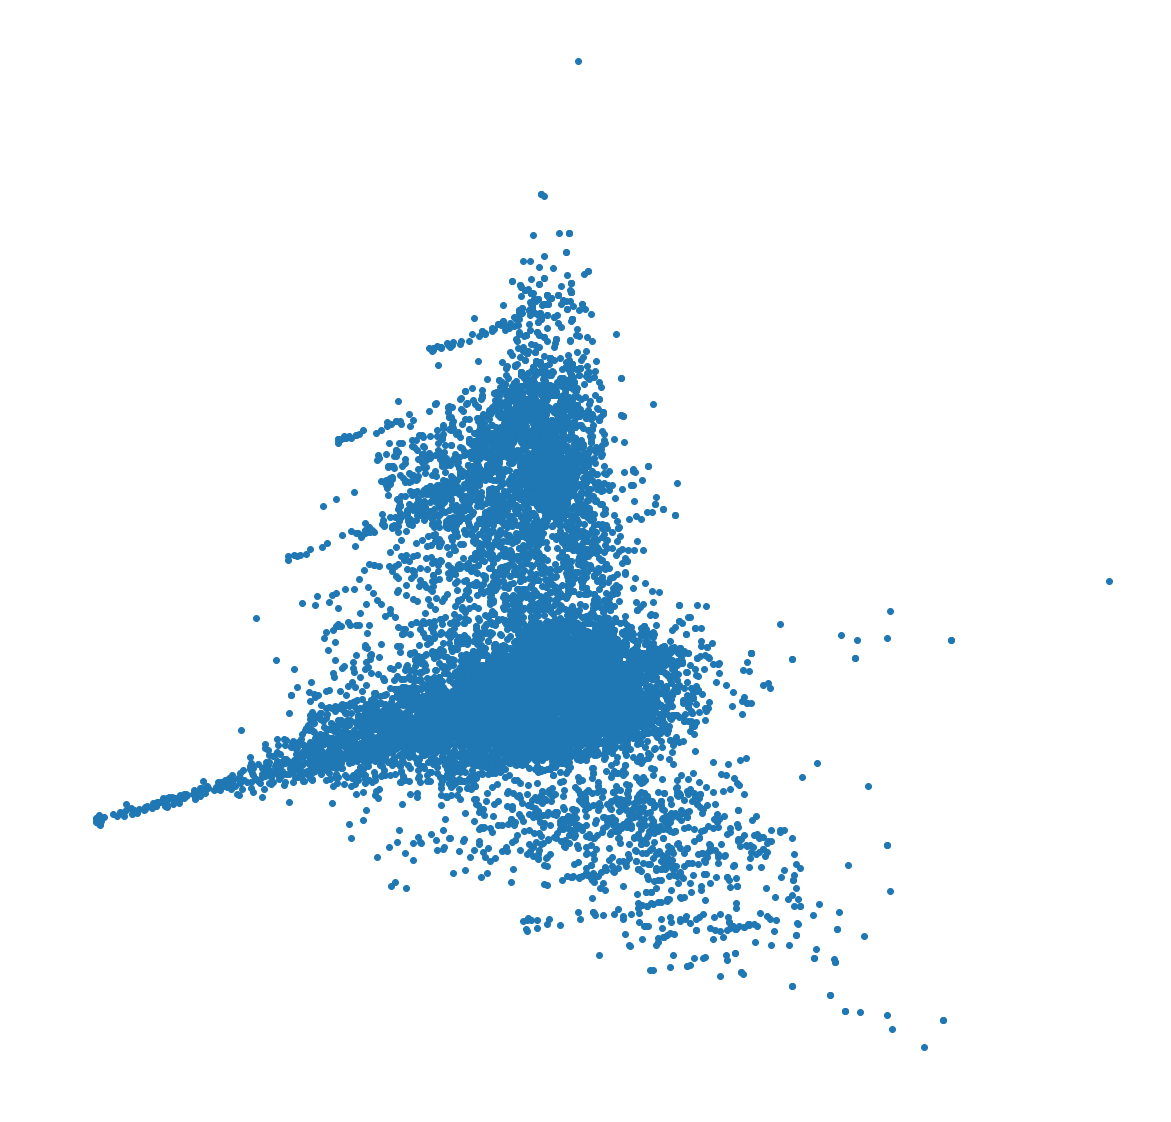

In [191]:
plt.figure(figsize=(20, 20))
plt.scatter(t[0], t[1])
plt.axis("off")

# for i, txt in enumerate(n):
#     plt.annotate(txt, (y[i], z[i]), fontsize = 20)

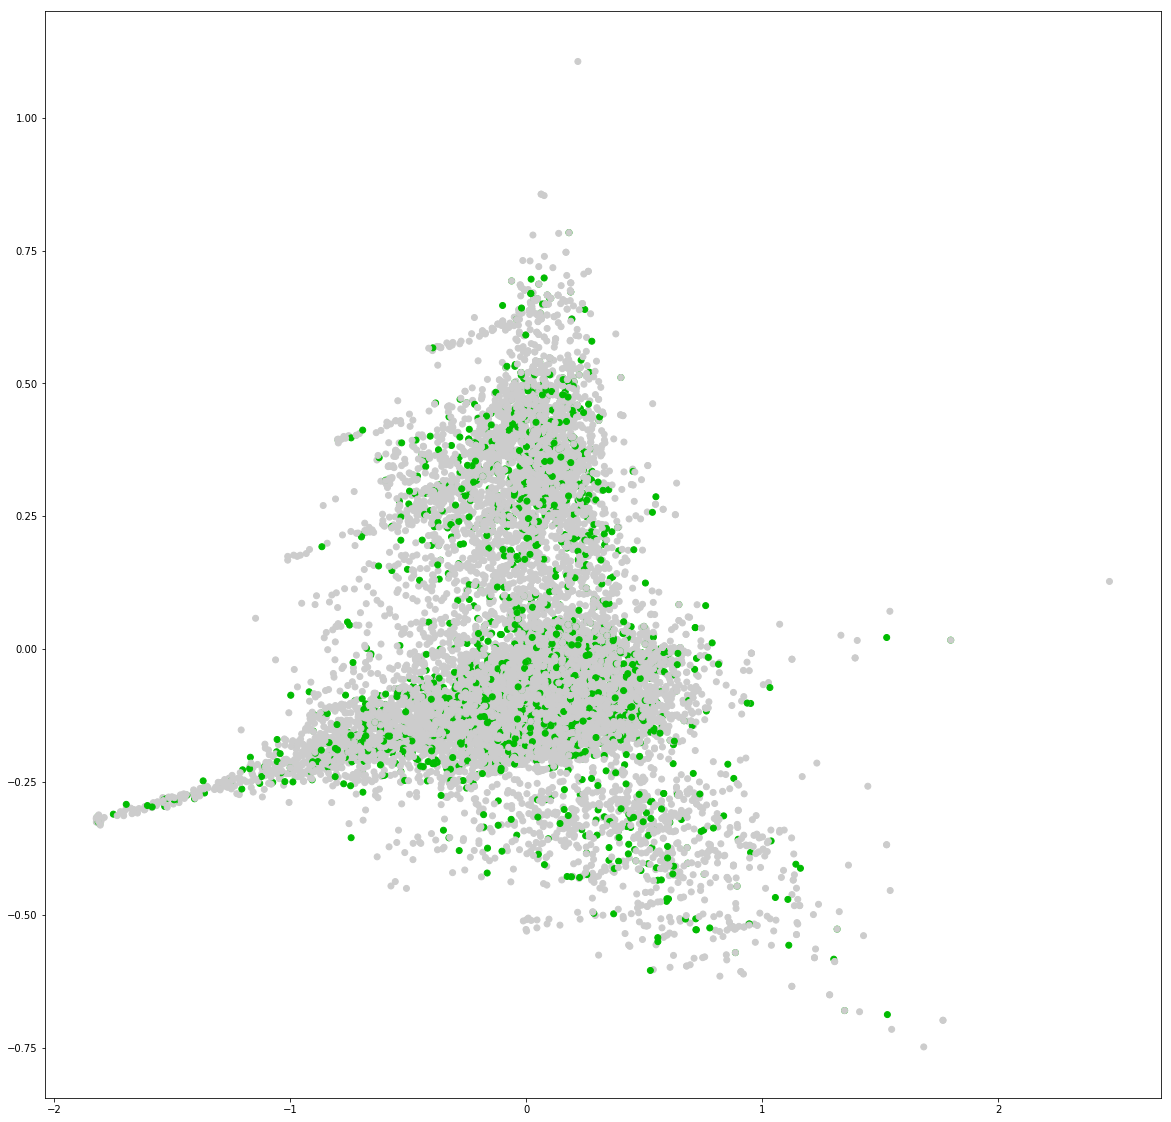

In [190]:
from sklearn.cluster import KMeans;
import matplotlib
cluster = KMeans(2);
cluster.fit(word2vec_value);

cluster.labels_ = labe;

plt.figure(figsize=(20, 20))
plt.scatter(t[0],t[1], c=[matplotlib.cm.spectral(float(i)/2) for i in cluster.labels_]);

In [158]:
cluster.labels_ = [1,2.4]

In [159]:
cluster.labels_

[1, 2.4]

In [185]:
yui = list(pd.read_csv('all_files.csv')['query-type'])
labe = []

for i in yui:
    flg = 0
#     for k,j in enumerate(querytype_list):
    if i == 'Fertilizer Use and Availability' :
        labe.append(1)
        flg = 1

    if flg != 1:
        labe.append(60)
        

In [186]:
labe



[1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 1,
 1,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 1,
 60,
 60,
 1,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 6

In [184]:
querytype_list

['Cold Storage',
 'Weed Management',
 'Animal Nutrition',
 'Tank, Pond and Reservoir Management',
 'Storage',
 'Breeding and culture of ornamental fish',
 'Sowing Time and Weather',
 'Soil Testing\t',
 '\tPlant Protection\t',
 'Cattle shed Planning and Management',
 'Post Harvest Preservation',
 'Soil Testing',
 'Vegetative Propagation and Tissue Culture',
 'Fishery Mechanization',
 'Fish Fingerling Production',
 'Breeding of freshwater prawn',
 'Bio-Pesticides and Bio-Fertilizers',
 'Market Information',
 'Crop Insurance',
 'Cultural Practices\t',
 'Landscaping',
 'Training and Exposure Visits',
 'Dairy Production',
 'Nursery Management',
 'Mushroom Production',
 'Post Harvest Management (Cleaning, Grading, Packaging, Food Processing, Cool Chain etc.)',
 '\tMaket Information\t',
 'Livestock Products Processing and Packaging',
 'Agriculture Mechanization\t',
 'Organic Farming',
 'Animal Production (Piggery, Goatery, Sheep Farming etc.)',
 'Nutrient Management',
 'Water Management, Micr